<a href="https://colab.research.google.com/github/rayhen-02/DSC-212-Assignment/blob/main/DSC_212_assignment_IMS24188.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1 Importing Libraries
1) network: Handling graph structure and social network analysis

2) numpy	Numerical operations, matrix manipulation

3) scipy.linalg	Eigenvalue decomposition for spectral splitting

4) matplotlib	Plotting graph communities and iteration

In [1]:
import networkx as nx
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt


Karate Club Graph: lOAD

This function loads the Zachary’s Karate Club dataset.
Every node represents a club member and edges represent friendship.
We also create a community attribute initialized to community 0 for all nodes.

In [2]:
def load_karate_club():
    G = nx.karate_club_graph()
    for node in G.nodes():
        G.nodes[node]['community'] = 0
    return G


# **Modularity Matrix Calculation**

### Computes Newman-Girvan Modularity Matrix (B) used for community detection:
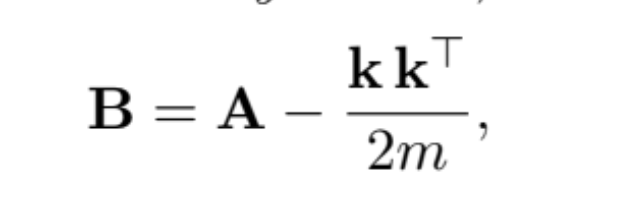
Where:
1) A	Adjacency matrix of graph

2) k	Degree vector (number of connections for each node)

3) m	Total number of edges

4) B	Modularity matrix used for spectral splitting

In [3]:
def calculate_modularity_matrix(G):

    A = nx.adjacency_matrix(G).todense()
    m = G.number_of_edges()
    n = G.number_of_nodes()
    k_list = [G.degree(node) for node in G.nodes()]
    k = np.array(k_list).reshape((n, 1))
    if 2 * m == 0:
       return np.zeros((n, n))
    expected_edges = np.outer(k, k) / (2 * m)
    B = A - expected_edges
    return B


# **Spectral Splitting Step** *italicised text*

**Performs eigenvalue decomposition on the modularity matrix.**

The leading eigenvector splits nodes into two groups:

### Positive entry	Group +1
### Negative entry	Group -1 *italicised text*

If the largest eigenvalue λ1 is positive, splitting increases modularity.

In [4]:
def spectral_split(G_subgraph):

   B_sub = calculate_modularity_matrix(G_subgraph)
   eigenvalues, eigenvectors = scipy.linalg.eigh(B_sub)
   lambda1 = eigenvalues[-1]
   u1 = eigenvectors[:, -1]
   s = np.where(u1 > 0, 1, -1)
   return lambda1, s


# **Compute Graph Metrics**

**Calculates four centrality metrics for network analysis:**

1) Degree centrality	- Direct connections count

2) Betweenness centrality -	Node as a bridge in shortest paths

3) Closeness centrality - How fast a node can reach others

4) Clustering coefficient - Local connectivity density

In [5]:
def compute_metrics(G):

    metrics = {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'clustering': nx.clustering(G)
    }
    return metrics


# **Graph Visualization**

Draws the graph with nodes colored according to their assigned community.
spring_layout ensures stable node positioning for visual consistency across iterations.

In [6]:
def draw_graph(G, iteration, pos):

   community_map = nx.get_node_attributes(G, 'community')
   node_colors = [community_map[node] for node in G.nodes()]
   plt.figure(figsize=(8, 8))
   nx.draw_networkx(
        G, pos,
        node_color=node_colors,
        cmap=plt.cm.get_cmap('Blues', max(node_colors) + 1),
        with_labels=True,
        node_size=300
    )
   plt.title(f"Iteration {iteration} - Community Split")
   plt.show()


# **Recursive Spectral Modularity Partitioning**


1️ Compute metrics and visualize graph

2️ Perform spectral split

3️ If largest eigenvalue λ1 > 0, split is beneficial

4️ Assign nodes into communities

5️ Continue splitting sub-communities using a queue

6️ Stop when no improvement occurs


In [7]:
def recursive_modularity_partitioning(G):

    node_names = list(G.nodes())
    all_metrics = {}
    current_communities = {node: 0 for node in node_names}
    fixed_pos = nx.spring_layout(G)
    current_community_id = 0
    queue = [(G, 0)]
    iteration = 0

    while queue:
        G_current, comm_id = queue.pop(0)
        if iteration > 0 or (iteration == 0 and comm_id == 0):
             all_metrics[iteration] = compute_metrics(G)
             draw_graph(G, iteration, fixed_pos)
             print(f"\nMetrics at iteration {iteration} (after split):")
             for metric_name in ['degree', 'betweenness', 'closeness', 'clustering']:
                 metric_dict = all_metrics[iteration][metric_name]
                 sorted_nodes = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)
                 print(f"{metric_name.capitalize()} Centrality (top 5):")
                 for node, value in sorted_nodes[:5]:
                     print(f"  Node {node}: {value:.4f}")
             print()
             iteration += 1

        subgraph_nodes = list(G_current.nodes())
        lambda1, s = spectral_split(G_current)

        if lambda1 <= 0:
            print(f"Community {comm_id} is stable (Lambda1 <= 0). Stopping recursion.")
            continue

        print(f"Community {comm_id} split is beneficial (Lambda1 = {lambda1:.4f} > 0).")

        next_comm_id = max(current_communities.values()) + 1

        group_plus_nodes = [subgraph_nodes[i] for i, sign in enumerate(s) if sign == 1]
        group_minus_nodes = [subgraph_nodes[i] for i, sign in enumerate(s) if sign == -1]

        if not group_plus_nodes or not group_minus_nodes:
            print(f"Split of Community {comm_id} was trivial. Stopping.")
            continue

        for node in group_minus_nodes:
            G.nodes[node]['community'] = next_comm_id
            current_communities[node] = next_comm_id

        for node in group_plus_nodes:
             G.nodes[node]['community'] = comm_id
             current_communities[node] = comm_id

        G_plus = G.subgraph(group_plus_nodes).copy()
        G_minus = G.subgraph(group_minus_nodes).copy()

        queue.append((G_plus, comm_id))
        queue.append((G_minus, next_comm_id))

    all_metrics[iteration] = compute_metrics(G)

    draw_graph(G, iteration, fixed_pos)

    print(f"\nFinal Metrics at iteration {iteration}:")
    for metric_name in ['degree', 'betweenness', 'closeness', 'clustering']:
        metric_dict = all_metrics[iteration][metric_name]
        sorted_nodes = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)
        print(f"{metric_name.capitalize()} Centrality (top 5):")
        for node, value in sorted_nodes[:5]:
            print(f"  Node {node}: {value:.4f}")
    print()


    return all_metrics, current_communities


# **Test the Algorithm**

**This section:**

1) Loads the Karate Club graph

2) Runs full recursive spectral modularity detection

3) Prints final node–community assignments

/tmp/ipython-input-2506651022.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Blues', max(node_colors) + 1),


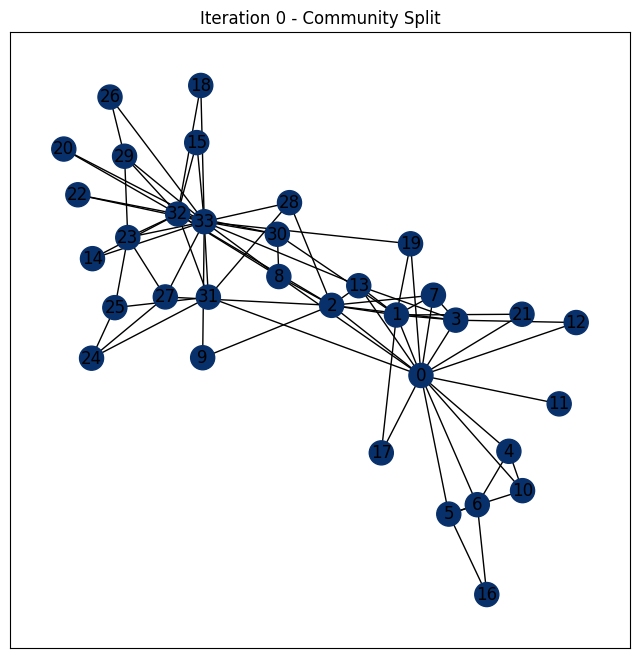


Metrics at iteration 0 (after split):
Degree Centrality (top 5):
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636
  Node 2: 0.3030
  Node 1: 0.2727
Betweenness Centrality (top 5):
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452
  Node 2: 0.1437
  Node 31: 0.1383
Closeness Centrality (top 5):
  Node 0: 0.5690
  Node 2: 0.5593
  Node 33: 0.5500
  Node 31: 0.5410
  Node 8: 0.5156
Clustering Centrality (top 5):
  Node 7: 1.0000
  Node 12: 1.0000
  Node 14: 1.0000
  Node 15: 1.0000
  Node 16: 1.0000

Community 0 split is beneficial (Lambda1 = 17.1074 > 0).


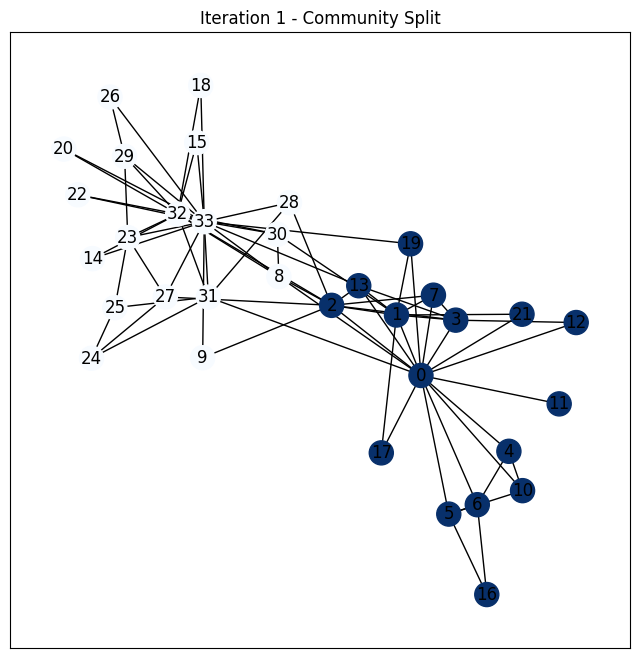


Metrics at iteration 1 (after split):
Degree Centrality (top 5):
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636
  Node 2: 0.3030
  Node 1: 0.2727
Betweenness Centrality (top 5):
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452
  Node 2: 0.1437
  Node 31: 0.1383
Closeness Centrality (top 5):
  Node 0: 0.5690
  Node 2: 0.5593
  Node 33: 0.5500
  Node 31: 0.5410
  Node 8: 0.5156
Clustering Centrality (top 5):
  Node 7: 1.0000
  Node 12: 1.0000
  Node 14: 1.0000
  Node 15: 1.0000
  Node 16: 1.0000

Community 0 split is beneficial (Lambda1 = 13.0854 > 0).
Split of Community 0 was trivial. Stopping.


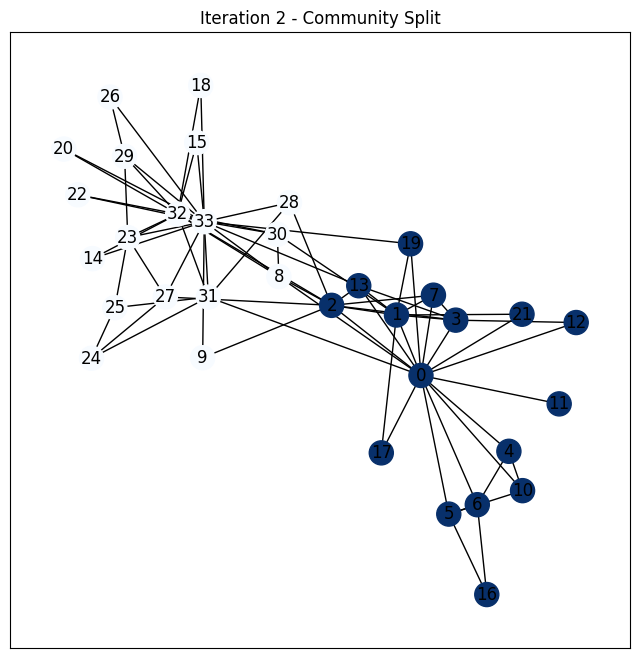


Metrics at iteration 2 (after split):
Degree Centrality (top 5):
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636
  Node 2: 0.3030
  Node 1: 0.2727
Betweenness Centrality (top 5):
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452
  Node 2: 0.1437
  Node 31: 0.1383
Closeness Centrality (top 5):
  Node 0: 0.5690
  Node 2: 0.5593
  Node 33: 0.5500
  Node 31: 0.5410
  Node 8: 0.5156
Clustering Centrality (top 5):
  Node 7: 1.0000
  Node 12: 1.0000
  Node 14: 1.0000
  Node 15: 1.0000
  Node 16: 1.0000

Community 1 split is beneficial (Lambda1 = 13.7824 > 0).


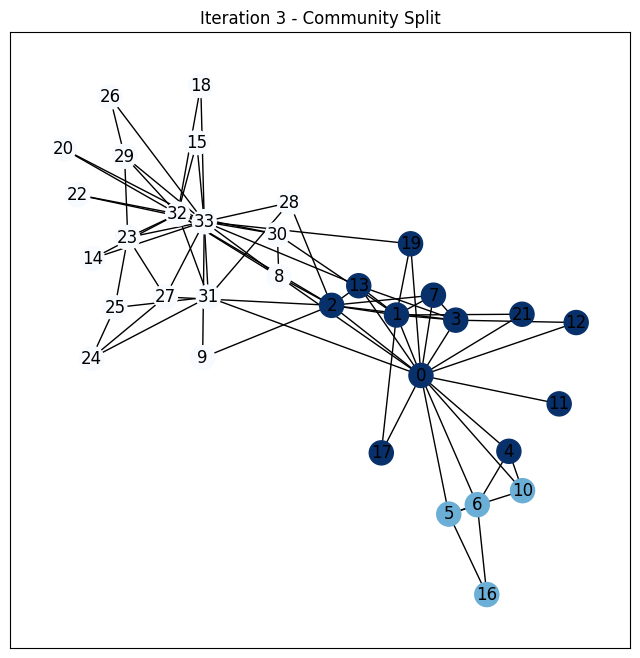


Metrics at iteration 3 (after split):
Degree Centrality (top 5):
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636
  Node 2: 0.3030
  Node 1: 0.2727
Betweenness Centrality (top 5):
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452
  Node 2: 0.1437
  Node 31: 0.1383
Closeness Centrality (top 5):
  Node 0: 0.5690
  Node 2: 0.5593
  Node 33: 0.5500
  Node 31: 0.5410
  Node 8: 0.5156
Clustering Centrality (top 5):
  Node 7: 1.0000
  Node 12: 1.0000
  Node 14: 1.0000
  Node 15: 1.0000
  Node 16: 1.0000

Community 1 split is beneficial (Lambda1 = 5.6770 > 0).
Split of Community 1 was trivial. Stopping.


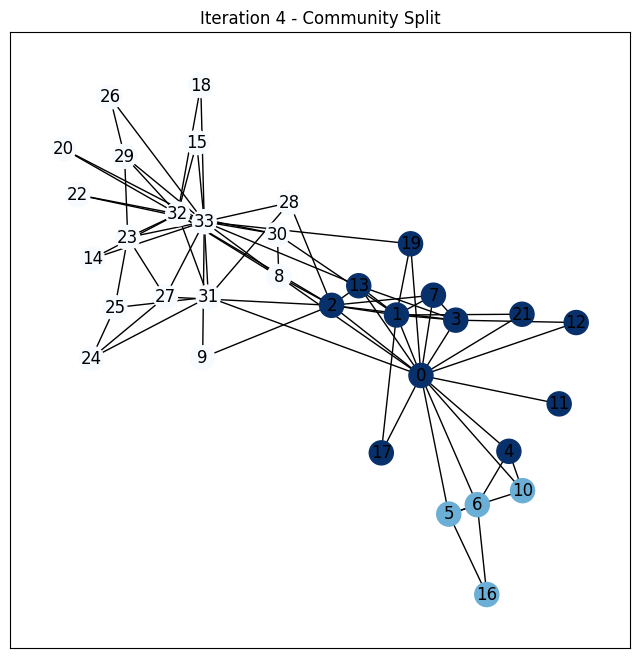


Metrics at iteration 4 (after split):
Degree Centrality (top 5):
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636
  Node 2: 0.3030
  Node 1: 0.2727
Betweenness Centrality (top 5):
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452
  Node 2: 0.1437
  Node 31: 0.1383
Closeness Centrality (top 5):
  Node 0: 0.5690
  Node 2: 0.5593
  Node 33: 0.5500
  Node 31: 0.5410
  Node 8: 0.5156
Clustering Centrality (top 5):
  Node 7: 1.0000
  Node 12: 1.0000
  Node 14: 1.0000
  Node 15: 1.0000
  Node 16: 1.0000

Community 2 split is beneficial (Lambda1 = 12.8937 > 0).
Split of Community 2 was trivial. Stopping.


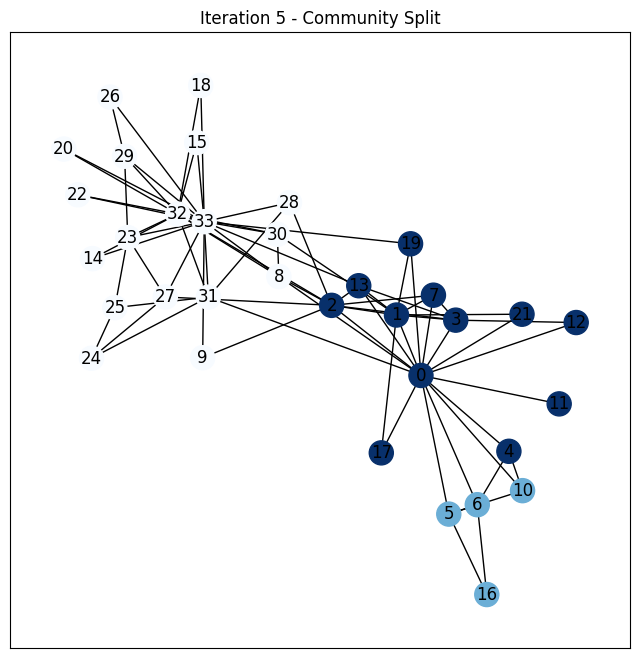


Final Metrics at iteration 5:
Degree Centrality (top 5):
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636
  Node 2: 0.3030
  Node 1: 0.2727
Betweenness Centrality (top 5):
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452
  Node 2: 0.1437
  Node 31: 0.1383
Closeness Centrality (top 5):
  Node 0: 0.5690
  Node 2: 0.5593
  Node 33: 0.5500
  Node 31: 0.5410
  Node 8: 0.5156
Clustering Centrality (top 5):
  Node 7: 1.0000
  Node 12: 1.0000
  Node 14: 1.0000
  Node 15: 1.0000
  Node 16: 1.0000


Community 0: 8 9 14 15 18 20 22 23 24 25 26 27 28 29 30 31 32 33 
Community 1: 5 6 10 16 
Community 2: 0 1 2 3 4 7 11 12 13 17 19 21 


In [8]:
if __name__ == '__main__':

    G_karate = load_karate_club()
    final_metrics, final_communities = recursive_modularity_partitioning(G_karate)
    sorted_communities = sorted(final_communities.items(), key=lambda item: item[1])
    current_comm_id = None
    for node, comm_id in sorted_communities:
        if comm_id != current_comm_id:
            print(f"\nCommunity {comm_id}: ", end="")
            current_comm_id = comm_id
        print(f"{node}", end=" ")
    print()
